In [2]:
import os
import datetime

import numpy as np 
import gymnasium as gym
import ale_py

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    SummaryWriter = None  # type: ignore[misc, assignment]

gym.register_envs(ale_py)

env = gym.make('PongDeterministic-v4')
observation, info = env.reset()
print(observation.shape)

(210, 160, 3)


A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


In [3]:
# hyperparameters
BATCH_SIZE = 4 # every how many episodes to do a param update?
GAMMA = 0.99 # discount factor for reward
DECAY_RATE = 0.99  # decay factor for RMSProp leaky sum of grad^2
HIDDEN_LAYER_NEURONS = 200
INPUT_DIMENSIONS = 80 * 80 # state size passed to neural network model
LR = 1e-3 # learning rate
EPSILON = 1e-8 #epsilon in RMSProp formula

ALGO="rmsprop"
SAVE_PATH = f"./models/checkpoint-pong_{ALGO}.pth"
RESUME = False # resume from previous checkpoint?


## Define Model, Optimizer, Loss with Torch

<img src="images/cross_entropy.png" width="auto" />

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Prioritize device: CUDA > MPS > CPU
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA is available. Using CUDA.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("MPS backend is available. Using MPS.")
else:
    DEVICE = torch.device("cpu")
    print("Neither CUDA nor MPS is available. Using CPU.")

# It works better on CPU, then on MPS, keep this way
DEVICE = torch.device("cpu")

class Model(nn.Module):

    def __init__(self, img_size, hidden_layer_neurons):
        """Initialize parameters and build model.
        Params
        ======
            img_size (int): Dimension of each state
            hidden_layer_neurons (int): Number of hidden neurons 
        """
        super(Model, self).__init__()

        self.fc1 = nn.Linear(img_size, hidden_layer_neurons)
        self.fc2 = nn.Linear(hidden_layer_neurons, 1)
    
    def forward(self, state):
        """Build a network that maps state -> probability action up."""
        x = F.relu(self.fc1(state))
        output = F.sigmoid(self.fc2(x))

        return output

model = Model(INPUT_DIMENSIONS, HIDDEN_LAYER_NEURONS)

model.to(DEVICE)
if ALGO == "rmsprop":
    # we updated parameters 2nd time LR to 0.001 from 0.0001, EPSILON to  1e-8 from 1e-5 and alpha stays same, we don't have momentum like adam though
    optimizer = optim.RMSprop(model.parameters(), lr=LR, eps=EPSILON, alpha=DECAY_RATE)
else: 
    optimizer = torch.optim.Adam(model.parameters(), lr=7e-4)

MPS backend is available. Using MPS.


In [8]:
print(optimizer)

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0
)


## Image PreProcessing 

In [9]:
def downsample(image):
    # Take only alternate pixels - basically halves the resolution of the image (which is fine for us)
    return image[::2, ::2, :]

def remove_color(image):
    """Convert all color (RGB is the third dimension in the image)"""
    return image[:, :, 0]

def remove_background(image):
    image[image == 144] = 0  # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    return image

def preprocess_observations(input_observation, prev_processed_observation):
    """ convert the 210x160x3 uint8 frame into a 6400 float vector """
    processed_observation = input_observation[35:195] # crop
    processed_observation = downsample(processed_observation)
    processed_observation = remove_color(processed_observation)
    processed_observation = remove_background(processed_observation)
    processed_observation[processed_observation != 0] = 1 # everything else (paddles, ball) just set to 1
    
    # Step 3: Convert to PyTorch tensor directly on the correct device and flatten
    processed_observation = torch.Tensor(
        processed_observation, device=DEVICE
    ).flatten()  # Flatten to a 1D tensor of shape (6400,)

    # Step 4: Compute difference with previous frame to capture movement
    if prev_processed_observation is not None:
        input_observation = processed_observation - prev_processed_observation
    else:
        input_observation = torch.zeros_like(processed_observation)


    return processed_observation, input_observation

### Policy to select right action

In [10]:
def choose_action(probability):
    random_value = np.random.uniform()
    if random_value < probability:
        # signifies up in openai gym
        return 2
    else:
         # signifies down in openai gym
        return 3

In [11]:
def discount_rewards(rewards, gamma):
    """ Actions you took x steps before the end result are less important to the overall result than an action you took a step ago.
    This implements that logic by discounting the reward on previous actions based on how long ago they were taken
        discounted_future_reward[t] = \sum_{k=1} discount_factor^k * reward[t+k]"""

    discounted_rewards = torch.empty(len(rewards)).to(DEVICE)
    running_add = 0
    # Compute discounted_future_reward for each timestep by iterating backwards
    # from end of episode to beginning
    for t in  range(len(rewards) - 1, -1, -1):
        if rewards[t] != 0:
            # If rewards[t] != 0, we are at game boundary (win or loss) so we
            # reset discounted_future_reward to 0 (this is pong specific!)
            running_add = 0 
        running_add = running_add * gamma + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards

In [12]:
def preprocess_new(image):
    """ Pre-process 210x160x3 uint8 frame into 6400 (80x80) 1D float vector. """
    image = torch.Tensor(image) #converts to float 
    
    # Crop, downsample by factor of 2, and turn to grayscale by keeping only red channel
    image = image[35:195]
    image = image[::2,::2, 0]

    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1

    return image.flatten().float()

def run_episode(model, env):
    observation, _ = env.reset()
    action_chosen_log_probs, episode_rewards = [], []

    
    done = False 
    prev_processed_obs = preprocess_new(observation)
    reward_sum = 0
    timestep = 0
    

    while not done:
        processed_obs = preprocess_new(observation)
        # Preprocess the observation, set input to network to be difference
        # image between frames
        state = processed_obs - prev_processed_obs
        prev_processed_obs = processed_obs
        # print('State:', state.shape) # State: torch.Size([6400])

        # calculate probability of taking action up
        up_probability = model(state)

        action = choose_action(up_probability) # toss the coin, up or down 
        # see here: http://cs231n.github.io/neural-networks-2/#losses
        # ∂L/∂f = predicted_label(0 or 1) - true_label(0 or 1) or (sigmoid(f) - y)
        # take negative of gradient to reduce error  when its added in future or -∂L/∂f = y - sigmoid(f)
        # fake_label = 1 if action == 2 else 0
        action_chosen_prob = up_probability if action ==  2 else (1 - up_probability)
        action_chosen_log_probs.append(torch.log(action_chosen_prob))
        
        # carry out the chosen action
        observation, reward, terminated, truncated, _ = env.step(action)
        reward_sum += reward
        episode_rewards.append(reward)
        
        prev_processed_obs = processed_obs
        done = truncated or terminated
        timestep += 1

    action_chosen_log_probs = torch.cat(action_chosen_log_probs)
    episode_rewards = torch.tensor(episode_rewards, dtype=torch.float32, device=DEVICE)

    
    discounted_rewards = discount_rewards(episode_rewards, GAMMA)
    # print('Discounted:', discounted_rewards.shape)
    # Standardize the rewards to have mean 0, std. deviation 1 (helps control the gradient estimator variance).
    # It encourages roughly half of the actions to be rewarded and half to be discouraged, which
    # is helpful especially in beginning when positive reward signals are rare.
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / discounted_rewards.std()
    # print('Discounted:', discounted_rewards.shape)

    # Compute the loss for each step
    # weighted_loss = loss_per_step * discounted_rewards # e.g. discounted_rewards - shape: (20, 1), weighted_loss - (20, 1)
    # in numpy sample we use sum() of weighted loss if look at the code, we could use mean()
    # discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32, device=DEVICE)
    loss = -(discounted_rewards * action_chosen_log_probs).mean() # Take the mean of the weighted loss across steps for stabilizing gradients

    return loss, reward_sum
    

def train_new(model, env, start_time, last_batch, tf_writer, n_episodes=100000):
        
    i_episode = 1
    batch = last_batch + 1
    done = False    
    while not done:

        mean_batch_loss = 0
        mean_batch_reward = 0
        for batch_episode in range(BATCH_SIZE):
            # Run one episode
            loss, episode_reward = run_episode(model, env)
            mean_batch_loss += loss / BATCH_SIZE
            mean_batch_reward += episode_reward / BATCH_SIZE

            # Boring book-keeping
            print(f'Episode {i_episode} reward total was {episode_reward}')
            i_episode += 1

        # Check if loss is NaN before backprop
        if torch.isnan(mean_batch_loss):
            print(f"NaN detected in loss at batch {batch}. Terminating training.")
            break  # Stop the entire training process if NaN is detected

        # Backprop after `batch_size` episodes
        optimizer.zero_grad()
        mean_batch_loss.backward()
        optimizer.step()

        # Batch metrics and tensorboard logging
        print(f'Batch: {batch}, mean loss: {mean_batch_loss:.4f}, '
              f'mean reward: {mean_batch_reward:.2f}')
        tf_writer.add_scalar('mean loss', mean_batch_loss.detach().item(), batch)
        tf_writer.add_scalar('mean reward', mean_batch_reward, batch)

        if batch % 25 == 0: 
            print('Saving checkpoint...')
            save_dict = {
                'model_weights': model.state_dict(),
                'start_time': start_time,
                'last_batch': batch
            }
            torch.save(save_dict, SAVE_PATH)
        
        if i_episode >= n_episodes:
            done = True
        
        batch += 1


In [19]:
# Set up tensorboard logging
if RESUME: 
    print('Loading from checkpoint...')
  
    save_dict = torch.load(SAVE_PATH)

    model.load_state_dict(save_dict['model_weights'])
    start_time = save_dict['start_time']
    last_batch = save_dict['last_batch']
else:
    start_time = datetime.datetime.now().strftime("%H.%M.%S-%m.%d.%Y")
    last_batch = -1

tf_writer = 10(os.path.join('runs', start_time + f'-{ALGO}'))
train_new(model, env, start_time, last_batch, tf_writer, n_episodes=1000)  # so main error we had was in discount calculatiosn when we gave there in (n,1) array instead of (n,)


Episode 1 reward total was -21.0
Episode 2 reward total was -21.0
Episode 3 reward total was -21.0
Episode 4 reward total was -21.0
Batch: 0, mean loss: -0.0000, mean reward: -21.00
Saving checkpoint...
Episode 5 reward total was -20.0
Episode 6 reward total was -18.0
Episode 7 reward total was -21.0
Episode 8 reward total was -21.0
Batch: 1, mean loss: -0.0005, mean reward: -20.00
Episode 9 reward total was -20.0
Episode 10 reward total was -20.0
Episode 11 reward total was -20.0
Episode 12 reward total was -20.0
Batch: 2, mean loss: 0.0024, mean reward: -20.00
Episode 13 reward total was -18.0
Episode 14 reward total was -20.0
Episode 15 reward total was -21.0
Episode 16 reward total was -20.0
Batch: 3, mean loss: 0.0015, mean reward: -19.75
Episode 17 reward total was -21.0
Episode 18 reward total was -19.0
Episode 19 reward total was -18.0
Episode 20 reward total was -20.0
Batch: 4, mean loss: 0.0001, mean reward: -19.50
Episode 21 reward total was -20.0
Episode 22 reward total was

## Watch results 

In [6]:
import os
import imageio
import numpy as np
from IPython.display import Video, display, HTML

def record_video(env, policy, out_directory, out_name, fps=60):
    """
    Generate a replay video of the agent and display it in the notebook.
    :param env: Environment to record.
    :param policy: Policy used to determine actions.
    :param out_directory: Path to save the video.
    :param fps: Frames per second.
    """
    images = []
    done = False
    observation, _ = env.reset()
    img = env.render()
    images.append(img)
    frame1 = preprocess_new(observation)

    while not done:
        # Take the action that maximizes the expected future reward
        frame2 = preprocess_new(observation)
        # Preprocess the observation, set input to network to be difference
        # image between frames
        state = frame2 - frame1
        frame1 = frame2

        # calculate probability of taking action up
        up_probability = policy(state)
        action = choose_action(up_probability) # toss the coin, up or down 

        observation, reward, terminated, truncated, _ = env.step(action) 
        img = env.render()
        images.append(img)
        done = terminated or truncated
    
    # Save the video
    video_path = os.path.join(out_directory, out_name)
    imageio.mimsave(video_path, [np.array(img) for img in images], fps=fps)
    
    # Display the video in Jupyter notebook
    display(Video(video_path, embed=True, width=640, height=480))

In [14]:
env = gym.make('PongDeterministic-v4', render_mode='rgb_array')
save_dict = torch.load('./models/checkpoint-pong_adam.pth')

model.load_state_dict(save_dict['model_weights'])
record_video(env, model, './videos', 'output_pong_adam.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [15]:
def train_old(model, env, n_episodes=100000):
    #BCELoss=−(y⋅log(~y) + (1-y)*log(1-~y) in case of single number ~y is prediction
    criterion = nn.BCELoss(reduction='none')  #  Binary Cross Entropy
    
    running_reward = None
    for i_episode in range(1, n_episodes+1):
        observation, info = env.reset()
  
        batch_predictions, batch_targets, episode_rewards = [], [], []
        
        done = False 
        prev_processed_obs = None
        reward_sum = 0
        loss = 0
        # prev_processed_obs = preprocess_observations(observation)

        while not done:
            processed_obs, state = preprocess_observations(observation, prev_processed_obs)
            # state = processed_obs - prev_processed_obs
            # prev_processed_obs = processed_obs

            # calculate probability of taking action up
            up_probability = model(state)
            batch_predictions.append(up_probability)

            action = choose_action(up_probability) # toss the coin, up or down 
            # see here: http://cs231n.github.io/neural-networks-2/#losses
            # ∂L/∂f = predicted_label(0 or 1) - true_label(0 or 1) or (sigmoid(f) - y)
            # take negative of gradient to reduce error  when its added in future or -∂L/∂f = y - sigmoid(f)
            fake_label = 1 if action == 2 else 0
            batch_targets.append(fake_label)

            # carry out the chosen action
            observation, reward, terminated, truncated, info = env.step(action)
            reward_sum += reward
            episode_rewards.append(reward)
        
            done = truncated or terminated
            prev_processed_obs = processed_obs

        episode_rewards = torch.tensor(episode_rewards, dtype=torch.float32, device=DEVICE)
        batch_predictions = torch.cat(batch_predictions)
        batch_targets = torch.tensor(batch_targets, dtype=torch.float32, device=DEVICE)
 

        discounted_rewards = discount_rewards(episode_rewards, GAMMA)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / discounted_rewards.std()

        # Compute the loss for each step(remember predictions always first, then targets to make loss work correctly)
        loss_per_step = criterion(batch_predictions, batch_targets) #  e.g. (20,) predictions and (20,) targets results in (20,) if 20 steps in episode  
        weighted_loss = loss_per_step * discounted_rewards # e.g. discounted_rewards - shape: (20, ), weighted_loss - (20, ) (we take negative loss-per-step as we want ascend)
    
        # in numpy sample we use sum() of weighted loss if look at the code, we could use mean()
        loss = weighted_loss.sum() / 4 # Take the mean of the weighted loss across steps for stabilizing gradients
       
        # Backward pass
        # calculate gradients with respect to the averaged loss
        loss.backward()

        # update parameters of model when episode is multiple of batch_size
        if i_episode % 4 == 0: 
            optimizer.step()  # update weights
            optimizer.zero_grad() # reset gradients, important! as for batch_size (10) gradient already was accumulating by torch
            print("loss :", loss.item())
            # loss = 0


        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('\r %f resetting env. episode reward total was %f. running mean: %f' % (i_episode, reward_sum, running_reward))
        if i_episode % 100 == 0: 
           torch.save(model.state_dict(), SAVE_PATH)

In [ ]:
train_old(model, env, n_episodes=1000)  # so main error we had was in discount calculatiosn when we gave there in (n,1) array instead of (n,)

In [17]:
from IPython.display import Image, display
import imageio
import numpy as np
import os

def record_video_as_gif(env, policy, out_directory, fps=30, gif_name="replay.gif"):
    """
    Generate a replay GIF of the agent and display it in the notebook.
    :param env: Environment to record.
    :param policy: Policy used to determine actions.
    :param out_directory: Path to save the video and GIF.
    :param fps: Frames per second.
    :param gif_name: Name of the GIF file to save.
    """
    images = []
    done = False
    observation, _ = env.reset()
    img = env.render()
    images.append(img)
    frame1 = preprocess_new(observation)

    while not done:
        # Take the action that maximizes the expected future reward
        frame2 = preprocess_new(observation)
        # Preprocess the observation, set input to network to be difference
        # image between frames
        state = frame2 - frame1
        frame1 = frame2

        # calculate probability of taking action up
        up_probability = policy(state)
        action = choose_action(up_probability)  # toss the coin, up or down 

        observation, reward, terminated, truncated, _ = env.step(action) 
        img = env.render()
        images.append(img)
        done = terminated or truncated
    
    # Save the GIF
    gif_path = os.path.join(out_directory, gif_name)
    imageio.mimsave(gif_path, [np.array(img) for img in images], fps=fps)
    
    # Display the GIF in Jupyter notebook
    display(Image(filename=gif_path, width=640, height=480))

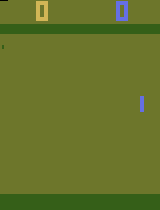

In [20]:
env = gym.make('PongDeterministic-v4', render_mode='rgb_array')
save_dict = torch.load('./models/checkpoint-pong_adam.pth')

model.load_state_dict(save_dict['model_weights'])
record_video_as_gif(env, model, './videos', gif_name='output_pong_adam.gif')